<a href="https://colab.research.google.com/github/omondistep/Awesome_Python_Scripts/blob/main/garch2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Returns Data:
1      -3.990852
2       0.178731
3      -1.620197
4       5.645238
5       0.342466
          ...   
6284    1.105372
6285    0.006652
6286   -1.058229
6287   -1.147718
6288   -0.364473
Name: Price, Length: 6288, dtype: float64
Returns Dates:
1         1/4/2000
2         1/5/2000
3         1/6/2000
4         1/7/2000
5        1/10/2000
           ...    
6284    12/24/2024
6285    12/26/2024
6286    12/27/2024
6287    12/30/2024
6288    12/31/2024
Name: Date, Length: 6288, dtype: object
Formatted Returns Data:
          Dates   Returns
1    2000-01-04 -3.990852
2    2000-01-05  0.178731
3    2000-01-06 -1.620197
4    2000-01-07  5.645238
5    2000-01-10  0.342466
...         ...       ...
6284 2024-12-24  1.105372
6285 2024-12-26  0.006652
6286 2024-12-27 -1.058229
6287 2024-12-30 -1.147718
6288 2024-12-31 -0.364473

[6288 rows x 2 columns]


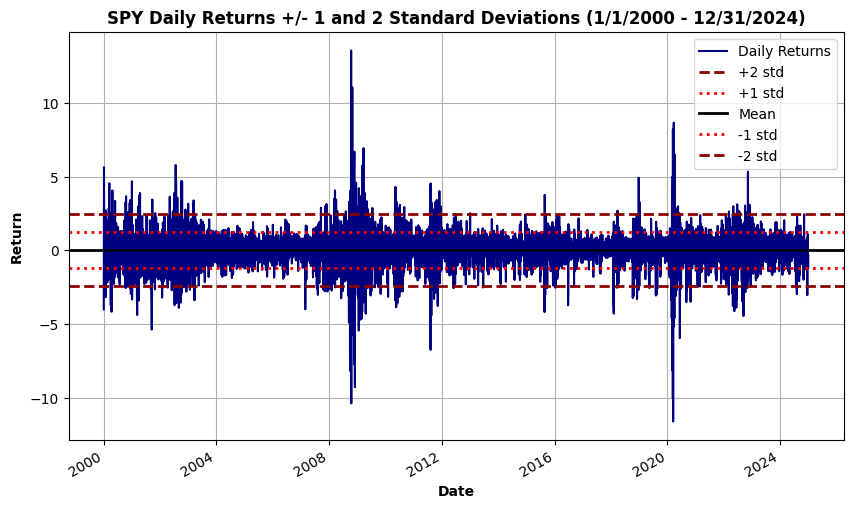

<Figure size 1000x600 with 0 Axes>

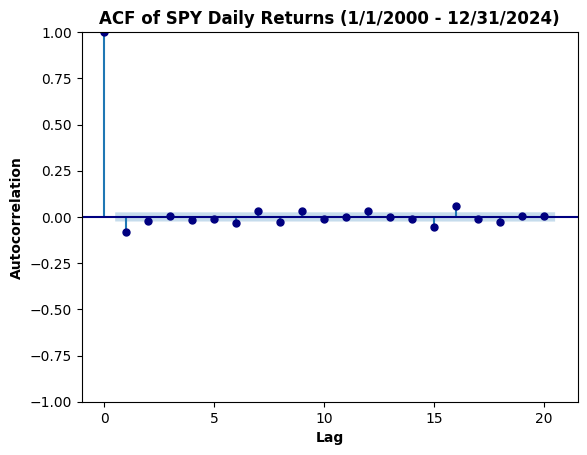

<Figure size 1000x600 with 0 Axes>

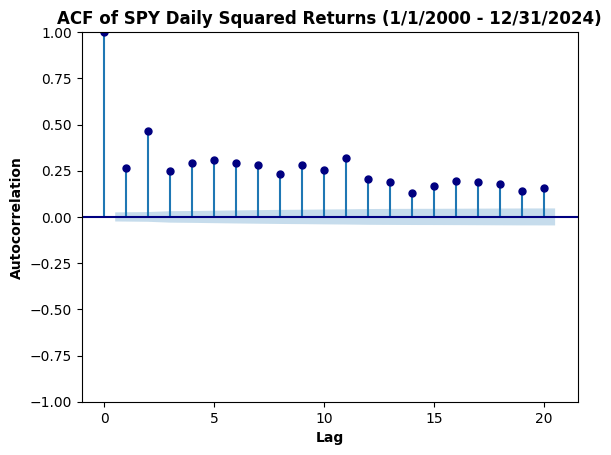

Rolling Realized Values:
[np.float64(0.38978952627285807), np.float64(0.38171205415622805), np.float64(0.3506118936975473), np.float64(0.3251105283248106), np.float64(0.31610586408327196), np.float64(0.344746551093695), np.float64(0.3406419762585034), np.float64(0.34346802684391325), np.float64(0.3420021530534444), np.float64(0.3058018530390958), np.float64(0.2982420707275376), np.float64(0.2910756071067089), np.float64(0.23294688617254827), np.float64(0.327314654846616), np.float64(0.32442786726011763), np.float64(0.3333014193430699), np.float64(0.36513886665063905), np.float64(0.39556346862302727), np.float64(0.4016415840041783), np.float64(0.40243548861705836), np.float64(0.39135500260574285), np.float64(0.43777919415548666), np.float64(0.4368713149762672), np.float64(0.4456310933662777), np.float64(0.47802377217421643), np.float64(0.47832581373710636), np.float64(0.5032372294027168), np.float64(0.4897434575387238), np.float64(0.5210740062946962), np.float64(0.5169024604365534), np.

In [ ]:
# Rolling volatility for forecasting
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from arch import arch_model

# Read CSV file from a folder
file_path = r"GARCH_Forecasts_Data.csv"
df = pd.read_csv(file_path)

# Compute returns and drop first observation NAN
# returns_data = df['Price'].pct_change()*100
returns_data = np.log(df['Price'] / df['Price'].shift(1)) * 100
returns_data = returns_data.iloc[1:]
print("Returns Data:")
print(returns_data)

# Get dates associated with returns
returns_dates = df['Date'].iloc[1:len(returns_data) + 1]
print("Returns Dates:")
print(returns_dates)

# Format dates and returns and create dataframe
returns_dates = pd.to_datetime(returns_dates)
returns_dates_df = pd.DataFrame({'Dates': returns_dates})
returns_realized = pd.DataFrame({'Returns': returns_data})
returns_data = pd.DataFrame({
    'Dates': returns_dates_df['Dates'],
    'Returns': returns_realized['Returns']
})
print("Formatted Returns Data:")
print(returns_data)

# Calculate the mean and standard deviation
mean_return = np.mean(returns_data['Returns'])
std_return = np.std(returns_data['Returns'])

# Plot returns, mean return, and plus and minus 1 and 2 standard deviations
plt.figure(figsize=(10, 6))  # Adjust figure size as needed
plt.plot(returns_data['Dates'], returns_data['Returns'], color='navy', linestyle='-', label='Daily Returns')

# Title and axis labels
plt.title("SPY Daily Returns +/- 1 and 2 Standard Deviations (1/1/2000 - 12/31/2024)", fontweight="bold")
plt.xlabel("Date", fontweight="bold")
plt.ylabel("Return", fontweight="bold")

# Add horizontal lines at +1 and -1 standard deviations
plt.axhline(mean_return + 2 * std_return, color='darkred', linestyle='dashed', linewidth=2, label='+2 std')
plt.axhline(mean_return + std_return, color='red', linestyle='dotted', linewidth=2, label='+1 std')
plt.axhline(mean_return, color='black', linestyle='solid', linewidth=2, label='Mean')
plt.axhline(mean_return - std_return, color='red', linestyle='dotted', linewidth=2, label='-1 std')
plt.axhline(mean_return - 2 * std_return, color='darkred', linestyle='dashed', linewidth=2, label='-2 std')

# Customize the plot
plt.grid(True)
plt.legend()
plt.gcf().autofmt_xdate()
plt.show()

# ACF plot of returns and squared returns
# Returns
plt.figure(figsize=(10, 6))  # Adjust figure size as needed
plot_acf(returns_data['Returns'], lags=20, alpha=0.05, color='navy')
plt.title("ACF of SPY Daily Returns (1/1/2000 - 12/31/2024)", fontweight="bold")
plt.xlabel("Lag", fontweight="bold")
plt.ylabel("Autocorrelation", fontweight="bold")
plt.show()

# Squared returns
plt.figure(figsize=(10, 6))  # Adjust figure size as needed
plot_acf(np.power(returns_data['Returns'], 2), lags=20, alpha=0.05, color='navy')
plt.title("ACF of SPY Daily Squared Returns (1/1/2000 - 12/31/2024)", fontweight="bold")
plt.xlabel("Lag", fontweight="bold")
plt.ylabel("Autocorrelation", fontweight="bold")
plt.show()

# Create array to store values
rolling_realized_values = []
rolling_forecast_values = []

# For loop to roll over data and calculate realized monthly volatility
for i in range(1255, len(returns_data) - 21):
    window_data = returns_data['Returns'].iloc[i:i + 22].values
    variance = np.var(window_data, ddof=1)
    rolling_realized_values.append(variance)
print("Rolling Realized Values:")
print(rolling_realized_values)

# For loop to roll over data for GARCH model
for i in range(0, len(returns_data) - 1255 - 21):
    # GARCH model specification GARCH(1,1)
    model = arch_model(returns_data['Returns'].iloc[i:i + 1256].values, mean='Zero',
                      vol='Garch', p=1, q=1, dist='normal')
    results = model.fit(disp='off')
    forecast = results.forecast(horizon=22)
    rolling_forecast_values.append(np.mean(forecast.variance.values[-1, :]))
print("Rolling Forecast Values:")
print(rolling_forecast_values)

# Concatenate dates, realized variance, and forecasted variance
results_dates_array = pd.to_datetime(df['Date'].iloc[1256:len(returns_data) - 20])
results_dates = pd.DataFrame({'Dates': results_dates_array})
results_realized = pd.DataFrame({'Realized Variance': rolling_realized_values})
results_forecasted = pd.DataFrame({'Forecasted Variance': rolling_forecast_values})
results_dates.reset_index(drop=True, inplace=True)
results = pd.DataFrame({
    'Dates': results_dates['Dates'],
    'Realized Variance': results_realized['Realized Variance'],
    'Forecasted Variance': results_forecasted['Forecasted Variance']
})

# Add to results dataframe for annualized one month realized and forecasted standard deviations
results['Realized Volatility'] = np.sqrt(results['Realized Variance']) * np.sqrt(252)
results['Forecasted Volatility'] = np.sqrt(results['Forecasted Variance']) * np.sqrt(252)

# Compute error metrics
results['Error'] = results['Realized Volatility'] - results['Forecasted Volatility']  # a
results['Squared Error'] = results['Error'] ** 2  # b
mse = results['Squared Error'].mean()  # c
rmse = np.sqrt(mse)  # d
positive_pct = (results['Error'] > 0).mean() * 100  # e
negative_pct = (results['Error'] < 0).mean() * 100  # e
avg_pos_err = results.loc[results['Error'] > 0, 'Error'].mean()  # f (positive magnitude)
avg_neg_err = results.loc[results['Error'] < 0, 'Error'].abs().mean()  # f (negative magnitude, absolute)

# Print all computed metrics
print("\n===== Error Metrics =====")
print(f"a. Errors: Computed as 'Realized Volatility - Forecasted Volatility'")
print(f"b. Squared Errors: Computed")
print(f"c. MSE: {mse:.6f}")
print(f"d. RMSE: {rmse:.6f}")
print(f"e. Positive Error %: {positive_pct:.2f}%")
print(f"  Negative Error %: {negative_pct:.2f}%")
print(f"f. Average Positive Error Magnitude: {avg_pos_err:.6f}")
print(f"  Average Negative Error Magnitude: {avg_neg_err:.6f}")

# Save results to file in the same directory
output_path = file_path.rsplit('\\', 1)[0] + '\\GARCH_Forecast_Results.csv'
results_df = results.copy()
results_df.loc[len(results_df)] = ['MSE', mse, '', '', '', '', mse, '']
results_df.loc[len(results_df)] = ['RMSE', '', '', '', '', '', rmse, '']
results_df.to_csv(output_path, index=False)
print(f"\nResults saved to {output_path} with MSE and RMSE included.")

# Copy results to clipboard
print("Results DataFrame:")
print(results)
results.to_clipboard(index=False, sep='\t')
print("\nResults copied to clipboard. Paste into Excel with Ctrl+V.")

# Plot realized versus forecasted volatility
plt.figure(figsize=(10, 6))  # Adjust figure size as needed
plt.plot(results['Dates'], results['Realized Volatility'], color='navy', linestyle='-', label='Realized Volatility')
plt.plot(results['Dates'], results['Forecasted Volatility'], color='darkred', linestyle='--', label='Forecasted Volatility')

# Customize the plot
plt.xlabel('Date', fontweight="bold")
plt.ylabel('Annualized One-Month Volatility', fontweight="bold")
plt.title('Realized versus Forecasted Volatility', fontweight="bold")
plt.grid(True)
plt.legend()
plt.gcf().autofmt_xdate()
plt.show()

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))